# ***VAE for image generation***
Consider VAE model from
*Auto-Encoding Variational Bayes (2014, D.P. Kingma et. al.)*.  
We will implement a VAE model using Torch and apply it to the MNIST dataset.


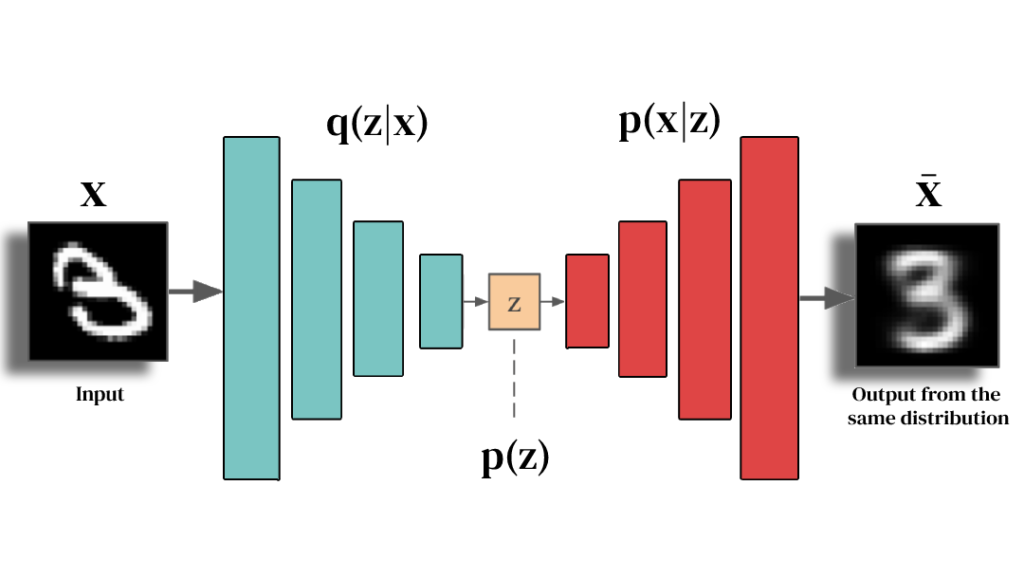


**Generative model:** We model each pixel value $\in \{0,1\}$ as a sample drawn from a Bernoulli distribution. Through a decoder, the latent random variable $z_n$  associated with an image $n$ is mapped to the success parameters of the Bernoulli distributions associated with the pixels of that image. Our generative model is described as follows:

$ z_n \sim N(0,I) $

$ \theta_n = g(z_n) $

$ x_n \sim Bern(\theta_n) $

where $g$ is the decoder. We choose the prior on $z_n$ to be the standard multivariate normal distribution, for computational convenience.  

**Inference model:** We infer the posterior distribution of $z_n$ via variational inference. The variational distribution $ q(z_n|x_n) $ is chosen to be multivariate Gaussian with a diagonal covariance matrix. The mean and covariance of this distribution are obtained by applying an encoder to $x_n$.

$ q(z_n|x_n) \sim q( \mu_n, \sigma^2_n) $

where $ \mu_n, \sigma^2_n = f(x_n)  $ and $f$ is the encoder.






**Implementation:**
Let's start with importing Torch and other necessary libraries:

In [1]:
import torch
import torch.nn as nn
import torch.distributions as dist

import numpy as np

from tqdm import tqdm

In [2]:
# Do not change the seeds
torch.manual_seed(0)
np.random.seed(0)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


### ***Step1: Model Hyperparameters***



In [4]:
dataset_path = '~/datasets'

batch_size = 128

# Dimensions of the input, the hidden layer, and the latent space.
x_dim  = 784
hidden_dim = 200
latent_dim = 20

# Learning rate
lr = 1e-3

# Number of epoch
epochs = 20

### ***Step2: Load Dataset***



In [5]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])


train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)
test_labels = test_dataset.targets

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.07MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.49MB/s]


### ***Step3: Define the model***


In [6]:
class Encoder(nn.Module):
    # encoder outputs the parameters of variational distribution "q"
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_enc1 = nn.Linear(input_dim, hidden_dim) # FC = fully connected layer
        self.FC_enc2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean = nn.Linear(hidden_dim, latent_dim)
        self.FC_std  = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        h_1     = self.LeakyReLU(self.FC_enc1(x))
        h_2     = self.LeakyReLU(self.FC_enc2(h_1))
        mu    = self.FC_mean(h_2)  # mean / location
        log_var = self.FC_std(h_2)   # log variance

        return mu, log_var

In [7]:
class Decoder(nn.Module):
    # decoder generates the success parameter of each pixel
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_dec1   = nn.Linear(latent_dim, hidden_dim)
        self.FC_dec2   = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, z):
        h_out_1  = self.LeakyReLU(self.FC_dec1(z))
        h_out_2  = self.LeakyReLU(self.FC_dec2(h_out_1))

        theta = torch.sigmoid(self.FC_output(h_out_2))
        return theta


**Q3.1 (2 points)**  Below implement the reparameterization function.

In [8]:
class Model(nn.Module):
    # it wrap the encoder and the decoder
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, std):
        # 1. Sample standard normal noise epsilon: epsilon ~ N(0, I)
        # Use torch.randn_like(mean) to ensure 'eps' has the same size and device
        # as 'mean' (or 'std').
        eps = torch.randn_like(mean)
        z = mean + eps * std
        return z

    def forward(self, x):
        # insert your code here
        mean, log_var = self.Encoder.forward(x)

        std = torch.sqrt(torch.exp(log_var))

        z = self.reparameterization(mean, std)

        theta = self.Decoder.forward(z)
        return theta, mean, log_var, z

### ***Step4: Model initialization***


In [9]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder)

model.to(device)


Model(
  (Encoder): Encoder(
    (FC_enc1): Linear(in_features=784, out_features=200, bias=True)
    (FC_enc2): Linear(in_features=200, out_features=200, bias=True)
    (FC_mean): Linear(in_features=200, out_features=20, bias=True)
    (FC_std): Linear(in_features=200, out_features=20, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
  (Decoder): Decoder(
    (FC_dec1): Linear(in_features=20, out_features=200, bias=True)
    (FC_dec2): Linear(in_features=200, out_features=200, bias=True)
    (FC_output): Linear(in_features=200, out_features=784, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
)

### ***Step5: Loss function and optimizer***


Our objective function is ELBO:
$E_{q(z)}\big[\log \frac{p(x,z)}{q(z)}\big]$

* **Q5.1 (1 point)** Show that ELBO can be rewritten as :

$E_{q(z)}\big[\log p(x|z)\big] - D_{KL} \big( q(z) \lvert \rvert  p(z)\big)$


*5.1 Your answer*

\begin{align*}
\mathcal{L} &= \mathbb{E}_{q(z)} \left[ \log \frac{p(x,z)}{q(z)} \right] = \int q(z) \cdot \log \frac{p(x,z)}{q(z)} \, dz \\
%
&= \int q(z) \cdot \log \frac{p(x|z) p(z)}{q(z)} \, dz \\
%
&= \int q(z) \cdot \log p(x|z) \, dz + \int q(z) \log \frac{p(z)}{q(z)} \, dz \\
%
&= \int q(z) \cdot \log p(x|z) \, dz - \int q(z) \log \frac{q(z)}{p(z)} \, dz \\
%
&= \mathbb{E}_{q(z)} \left[ \log p(x|z) \right] - D_{KL} \left( q(z) \| p(z) \right)
\end{align*}

Consider the first term: $E_{q(z|x)}\big(\log p(x|z)\big)$

$E_{q(z|x)}\big(\log p(x|z)\big) = \int q(z|x) \log p(x|z) dz $

We can approximate this integral by Monte Carlo integration as following:

$\approx \frac{1}{L} \sum_{l=1}^L \log p(x|z_l) $, where $z_l \sim q(z|x)$.

Now we can compute this term using the analytic expression for $p(x|z)$. ( Remember we model each pixel as a sample drawn from a Bernoulli distribution).

Consider the second term: $- D_{KL} \big( q(z|x) \lvert \rvert  p(z)\big)$

* **Q5.2 (2 points)** Kullback–Leibler divergence can be computed using the closed-form analytic expression when both the variational and the prior distributions are Gaussian. Write down this KL divergence in terms of the parameters of the prior and the variational distributions. Your solution should consider a generic case where the latent space is K-dimensional.

  *5.2 Your answer*

$$
- D_\text{KL}(q_\phi(z | x) || p_\theta (z)) = \dfrac{1}{2} \sum^K_{k = 1} \left[ 1 +
 \log(\sigma_k^2) - (\mu_k)^2 - \sigma_k^2 \right]
$$


**Q5.3 (2 points)** Now use your findings to implement the loss function, which is the negative of ELBO:

In [10]:
def loss_function(x, theta, mean, log_var): # should return the loss function (- ELBO)
    eps = 1e-9

    log_px_z = x * torch.log(theta + eps) + (1 - x) * torch.log(1 - theta + eps)
    log_px_z = log_px_z.sum(dim=1)
    recon_term = log_px_z.mean(dim=0)

    var = torch.exp(log_var)
    m_kl_per_sample = 0.5 * torch.sum(1 + log_var -var - mean.pow(2), dim=1)
    m_kl_term = m_kl_per_sample.mean(dim=0)

    elbo = recon_term + m_kl_term
    loss = -elbo
    return loss

### ***Step6: Train the model***

**Q6.1 (1 points)** Two lines of codes are missing in the training loop below, one to propagate the input through the model and another to compute the loss. Fill in the missing lines.

In [11]:
from torch.optim import Adam

print("Start training VAE...")
model.train()

# optimizer
optimizer = Adam(model.parameters(), lr=lr)
pbar = tqdm(range(epochs))
elbo = []
for epoch in pbar:
    total_loss = 0
    total_samples = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device)
        x = x.view(-1, x_dim)
        x = torch.round(x)

        optimizer.zero_grad()

        # insert your code here
        theta, mean, log_var,_= model.forward(x)

        loss = loss_function(x,theta,mean,log_var)
        loss.backward()
        optimizer.step()

        # loss.item() is the mean. Multiply by batch size to get the sum.
        total_loss += loss.item() * x.size(0)
        total_samples += x.size(0)

    # Correct global average
    avg_loss = total_loss / total_samples

    pbar.set_description(f"Epoch {epoch+1}/{epochs},"
                         f" Loss: {avg_loss:.4f},"
                         f" ELBO: {-avg_loss:.4f}")
    elbo.append(-avg_loss)

print("Finish!!")

Start training VAE...


Epoch 20/20, Loss: 84.5341, ELBO: -84.5341: 100%|██████████| 20/20 [04:21<00:00, 13.07s/it]

Finish!!


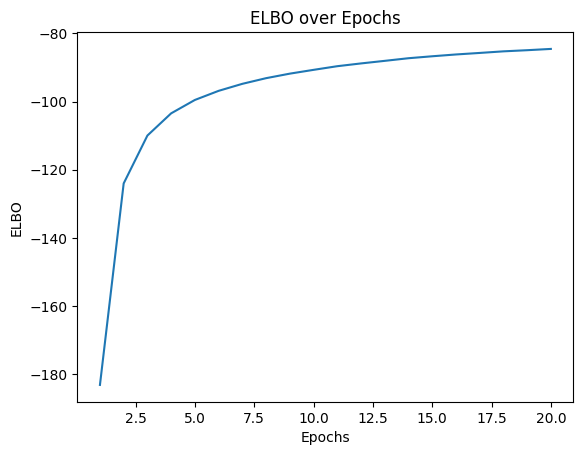

In [12]:
# Plot ELBO curve
import matplotlib.pyplot as plt
plt.plot(range(1, epochs + 1), elbo)
plt.xlabel('Epochs')
plt.ylabel('ELBO')
plt.title('ELBO over Epochs')
plt.show()

### ***Step7: Generate images from test dataset***
With our model trained, now we can start generating images.

First, we will generate images from the latent representations of test data.

Basically, we will sample $z$ from $q(z|x)$ and give it to the generative model (i.e., decoder) $p(x|z)$. The output of the decoder will be displayed as the generated image.

**Q7.1 (1 points)** Fill in the script below to get the latent representations of each batch in the test dataset and reconstruction of the final batch for display in the next cell.

In [13]:
model.eval()
# below we get decoder outputs for test data
with torch.no_grad():
    z_test = []
    x_test = []
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x_test.append(x)
        x = x.to(device)
        x = x.view(-1, x_dim)
        x = torch.round(x)
        # insert your code here
        theta,mean,log_var, z = model.forward(x=x)
        z_test.append(z.cpu().detach().numpy())

    # Save the last batch theta for visualization
    theta_batch = model.Decoder(z)

100%|██████████| 79/79 [00:01<00:00, 40.86it/s]


A helper function to display images:

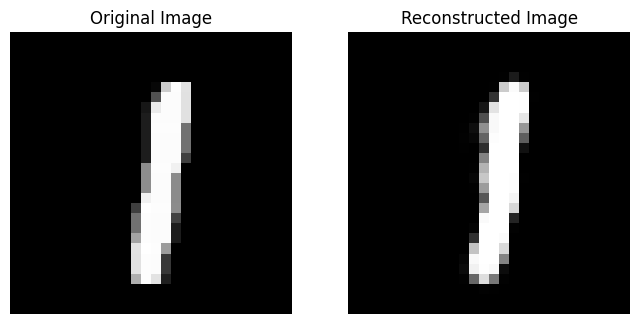

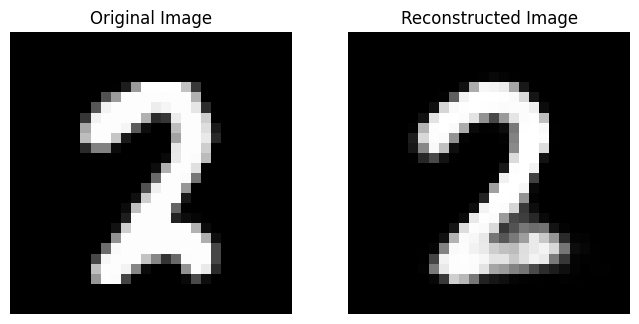

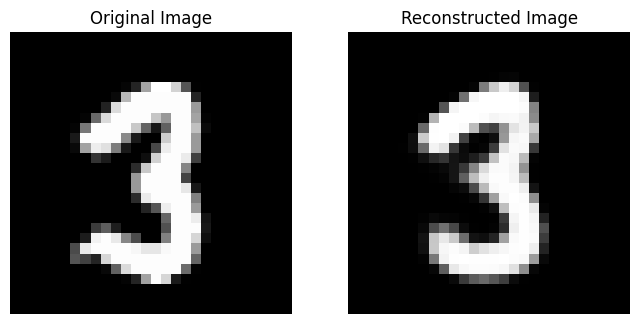

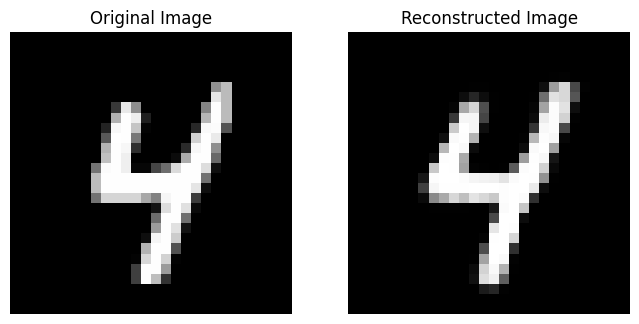

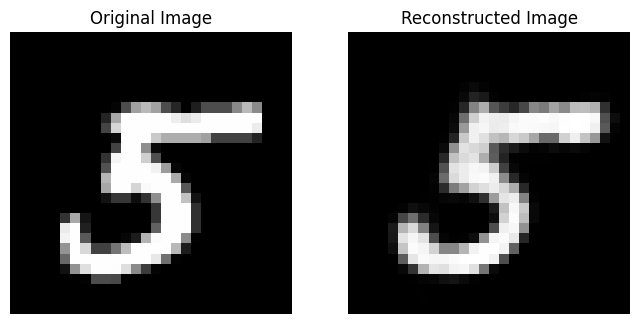

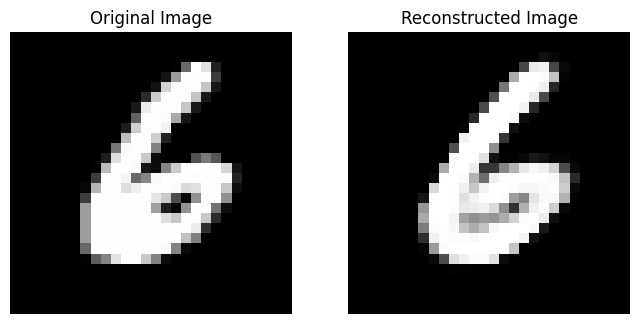

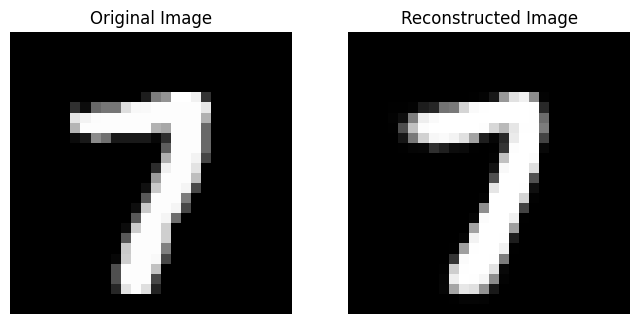

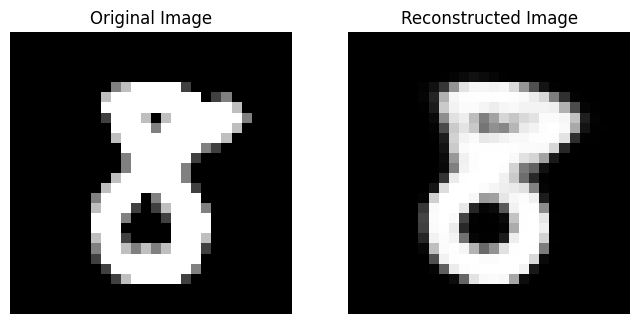

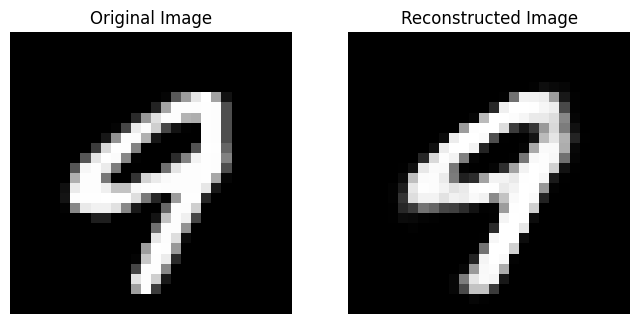

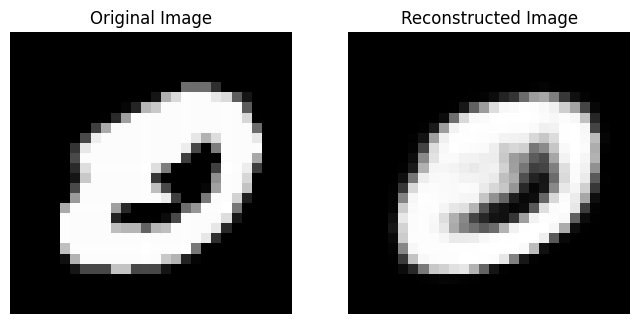

In [14]:
import matplotlib.pyplot as plt

def compare_images(x, theta, idx):
    # Reshape inputs to (Batch, 28, 28)
    # .cpu().detach().numpy() ensures we can handle tensors on GPU/with gradients
    x_img = x.view(-1, 28, 28)
    theta_img = theta.view(-1, 28, 28)

    # Create a figure with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Plot Original
    axes[0].imshow(x_img[idx].cpu().detach().numpy(), cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Plot Reconstruction
    axes[1].imshow(theta_img[idx].cpu().detach().numpy(), cmap='gray')
    axes[1].set_title("Reconstructed Image")
    axes[1].axis('off')

    plt.show()

# Call the function
theta_batch = theta_batch.cpu()
# theta_batch is the output of the decoder for the last batch in the test set
compare_images(x_test[-1], theta_batch, idx=0)
compare_images(x_test[-1], theta_batch, idx=1)
compare_images(x_test[-1], theta_batch, idx=2)
compare_images(x_test[-1], theta_batch, idx=3)
compare_images(x_test[-1], theta_batch, idx=4)
compare_images(x_test[-1], theta_batch, idx=5)
compare_images(x_test[-1], theta_batch, idx=6)
compare_images(x_test[-1], theta_batch, idx=7)
compare_images(x_test[-1], theta_batch, idx=8)
compare_images(x_test[-1], theta_batch, idx=9)